---
$$\Huge \text{Álgebra Lineal Computacional}$$
$$\Huge \text{Trabajo Práctico II}$$

$$\LARGE \text{Sistemas de Recomendación}$$

---

### **Alumno:** Jack

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para definir colormaps personalizados
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

In [2]:
# !pip install tqdm
# Barra de progreso
from tqdm import tqdm

In [3]:
# !pip install plotly
# Para graficar en 3D al final
import plotly.graph_objects as go

In [4]:
seed = 42
np.random.seed(seed)

# Ejercicio 1

### $\text{(a)}$ Carga de datos

Asumimos que el archivo con los datos `wine.csv` se encuentra en la misma carpeta que esta notebook.

Para la carga de datos usamos la librería Pandas, que permite, entre otras cosas, generar un DataFrame con los datos cargados para operar sobre ellos de una manera más cómoda.

En éste TP sólo usaremos esta librería para la carga y visualización de datos. Todas las operaciones posteriores se harán usando Numpy para respetar el formato de matrices que manejamos en la materia.

In [5]:
data = pd.read_csv('wine.csv', sep=',')

Lo primero que hacemos es verificar que los datos se hayan cargado en el formato correcto:

In [6]:
data

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


Los datos cargados contienen 178 filas de datos (*"observaciones"*) y 14 columnas, 13 de las cuales son características o *features* de los datos observados, y una última columna *Customer_Segment* representa la etiqueta o categoría a la cual ese vino particular pertenece.

### $\text{(b)}$ Separamos los datos

Separamos los datos en una matriz de variables independientes $X \in \mathbb R^{178 \times 13}$ con todas las características de todos los vinos, y un vector vertical $y \in \mathbb R^{178}$ con todas las etiquetas correspondientes:

In [7]:
num_indep = data.shape[1] - 1
X = data.iloc[:, 0:num_indep].values
y = data.iloc[:, -1].values

Desde este momento en adelante, perdimos la representación de los datos como DataFrame para representarlos como matrices de Numpy.

In [8]:
print(f"Dimensionalidad de X: {X.shape[0]} x {X.shape[1]}", )
print(f"Dimensionalidad de y: {y.shape[0]}")

Dimensionalidad de X: 178 x 13
Dimensionalidad de y: 178


### $\text{(c)}$ Normalización y centrado de los datos

Es necesario centrar y estandarizar los datos a desviación estándar 1 para evitar sesgos o grandes diferencias de escala en los datos que que puedan llevar al modelo predictivo a tener mayores errores de predicción.

En los siguientes dos gráficos podemos ver cómo ésto influye y es solucionado centrando y estandarizando los datos:

[]

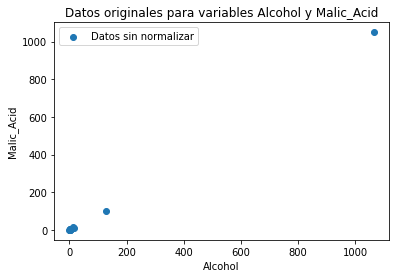

In [9]:
numvar1 = 0
numvar2 = 1

plt.scatter(X[numvar1], X[numvar2], label='Datos sin normalizar')

plt.title(f'Datos originales para variables {data.columns[numvar1]} y {data.columns[numvar2]}')

plt.xlabel(data.columns[numvar1])
plt.ylabel(data.columns[numvar2])

plt.legend(loc='upper left')
plt.plot()

Definimos la función `normalizar_datos` que resta la media y divide por la desviación estándar de cada columna por separado.

In [10]:
def normalizar_datos(X):
    """
    Normaliza los datos en la matriz X.

    Parameters:
    - X (numpy.ndarray): Matriz de datos a normalizar.

    Returns:
    - X_estandar (numpy.ndarray): Matriz normalizada.
    - X_mean (numpy.ndarray): Media de cada característica.
    - X_std (numpy.ndarray): Desviación estándar de cada característica.
    """
    n = X.shape[0]

    # Promedio sobre todas las filas (axis=0)
    X_mean = np.sum(X, axis=0) / n
    
    # Desviación estándar sobre todas las filas (axis=0)
    X_std = np.sqrt(np.sum((X - X_mean) ** 2, axis=0) / n)

    X_std_np = np.std(X, axis=0)

    # Estandarización
    X_estandar = (X - X_mean) / X_std

    return X_estandar, X_mean, X_std

Verificamos que la normalización de los datos centra los datos para toda variable independiente y estandariza su desviación estandar a 1:

In [11]:
X, X_mean, X_std = normalizar_datos(X)

print(f"Media de X: {X.mean(axis=0).round(2)}")
print(f"Desviación estándar de X: {X.std(axis=0).round(2)}")

Media de X: [-0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0.  0. -0.]
Desviación estándar de X: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Visualizamos los datos para cualquier par de variables independientes `numvar1` y `numvar2`:

[]

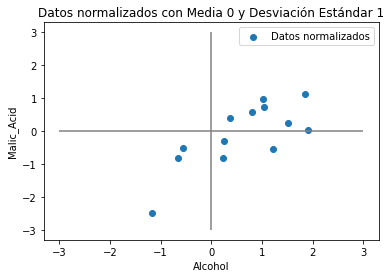

In [12]:
numvar1 = 0
numvar2 = 1

plt.scatter(X[numvar1], X[numvar2], label='Datos normalizados')

plt.hlines(0, -3, 3, color="gray")
plt.vlines(0, -3, 3, color="gray")

plt.title(f'Datos normalizados con Media 0 y Desviación Estándar 1')

plt.xlabel(data.columns[numvar1])
plt.ylabel(data.columns[numvar2])

plt.legend()
plt.plot()

Podemos observar como los datos quedan organizados en el mismo rango, mostrando una nube de puntos centrada en el cero.

### $\text{(d)}$ Matriz de Covarianza

La Matriz de Covarianza representa cómo las características de los datos están relacionadas entre sí en términos de sus variaciones conjuntas. Esta matriz se utiliza para analizar la dependencia y la dispersión conjunta de las características en el conjunto de datos. En nuestro caso con 13 características, la matriz de covarianza será una matriz en $\mathbb R^{13 \times 13}$, donde cada elemento de la matriz representa la covarianza entre dos características $x_i \in \mathbb R^{178}$ particulares.

Partiendo de:

$X \in \mathbb R ^ {178 \times 13}$

con  $x_i \in \mathbb R^{178}$ cada columna $i$ de $X$, $i \in [1,2,3, \dots, 13]$

Entonces tenemos que:

$$ X^t X = 
\begin{bmatrix}
  \langle x_1, x_1 \rangle & \langle x_1, x_2 \rangle & \langle x_1, x_3 \rangle & \ldots & \langle x_1, x_{13} \rangle \\
  \langle x_2, x_1 \rangle & \langle x_2, x_2 \rangle & \langle x_2, x_3 \rangle & \ldots & \langle x_2, x_{13} \rangle \\
  \langle x_3, x_1 \rangle & \langle x_3, x_2 \rangle & \langle x_3, x_3 \rangle & \ldots & \langle x_3, x_{13} \rangle \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  \langle x_{13}, x_1 \rangle & \langle x_{13}, x_2 \rangle & \langle x_{13}, x_3 \rangle & \ldots & \langle x_{13}, x_{13} \rangle \\
\end{bmatrix} \in \mathbb R ^ {13 \times 13}
$$

Como los valores originales están estandarizados, solo basta dividir cada uno de los elementos por la cantidad de filas u observaciones (178) de cada característica para obtener las covarianzas de nuestra matriz:

$$ \frac {X^t X}{178} = 
\begin{bmatrix}
  \text{Var}(x_1) & \text{Cov}(x_1, x_2) & \text{Cov}(x_1, x_3) & \ldots & \text{Cov}(x_1, x_{13}) \\
  \text{Cov}(x_2, x_1) & \text{Var}(x_2) & \text{Cov}(x_2, x_3) & \ldots & \text{Cov}(x_2, x_{13}) \\
  \text{Cov}(x_3, x_1) & \text{Cov}(x_3, x_2) & \text{Var}(x_3) & \ldots & \text{Cov}(x_3, x_{13}) \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  \text{Cov}(x_{13}, x_1) & \text{Cov}(x_{13}, x_2) & \text{Cov}(x_{13}, x_3) & \ldots & \text{Var}(x_{13}) \\
\end{bmatrix}
$$

Que como la desviación estándar de los datos es 1 para cada característica de datos, la varianza también será 1, lo que podemos escribir de manera explícita con unos en la diagonal:

$$ \frac {X^t X}{178} = 
\begin{bmatrix}
  1 & \text{Cov}(x_1, x_2) & \text{Cov}(x_1, x_3) & \ldots & \text{Cov}(x_1, x_{13}) \\
  \text{Cov}(x_2, x_1) & 1 & \text{Cov}(x_2, x_3) & \ldots & \text{Cov}(x_2, x_{13}) \\
  \text{Cov}(x_3, x_1) & \text{Cov}(x_3, x_2) & 1 & \ldots & \text{Cov}(x_3, x_{13}) \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  \text{Cov}(x_{13}, x_1) & \text{Cov}(x_{13}, x_2) & \text{Cov}(x_{13}, x_3) & \ldots & 1 \\
\end{bmatrix}
$$

Propiedades covarianza:

* **Simetría:** La matriz de covarianza es simétrica, lo que significa que la covarianza entre la característica $i$ y la característica $j$ es igual a la covarianza entre la característica $j$ y la característica $i$. Esta simetría refleja la **bidireccionalidad** de la relación entre las características.

* **Autovalores positivos:** Todos los autovalores de esta matriz son mayores a cero, pues es simétrica y parte de $X$ con columnas li.

* **Diagonal principal:** Los elementos en la diagonal principal de la matriz de covarianza representan la **varianza** de cada una de las 13 características por sí sola. Es decir, estos valores indican cuánto varían individualmente las características. Como los datos están estandarizados, este valor es siempre 1.

* **Valores en rango:** Todos los valores en la matriz de covarianza están entre -1 y 1.

* **Medida de la relación:** Los valores fuera de la diagonal principal indican cómo las características están relacionadas entre sí. Un valor positivo en una celda indica que las características tienden a cambiar en la misma dirección, mientras que un valor negativo sugiere que cambian en direcciones opuestas. La magnitud de estos valores refleja la fuerza de la relación y un valor cercano a cero indica que saber algo de una variable no me dice nada de la otra.



In [13]:
def matriz_covarianza(X):
    """
    Calcula la matriz de covarianza de los datos en la matriz X.

    Parameters:
    - X (numpy.ndarray): Matriz de datos.

    Returns:
    - cov_matrix (numpy.ndarray): Matriz de covarianza.
    """
    n = X.shape[0]
    return X.T.dot(X) / n

In [14]:
XTX = matriz_covarianza(X)

In [15]:
def test_covarianza(X):
    """
    Prueba la función de matriz de covarianza comparando su resultado con la función np.cov.

    Parameters:
    - X (numpy.ndarray): Matriz de datos.

    Returns:
    - resultado (bool): True si las matrices son cercanas (iguales), False en caso contrario.
    """
    XTX = matriz_covarianza(X)
    XTX_np = np.cov(X, rowvar=False, bias=True)

    # Verifico si XTX y XTX_np son "iguales"
    return np.allclose(XTX, XTX_np)

test_covarianza(X)

True

### Visualización de Matriz de Covarianza

In [16]:
# Cambio tamaño de la figura para visualizar mejor los números
plt.rcParams['figure.figsize'] = [12, 12]

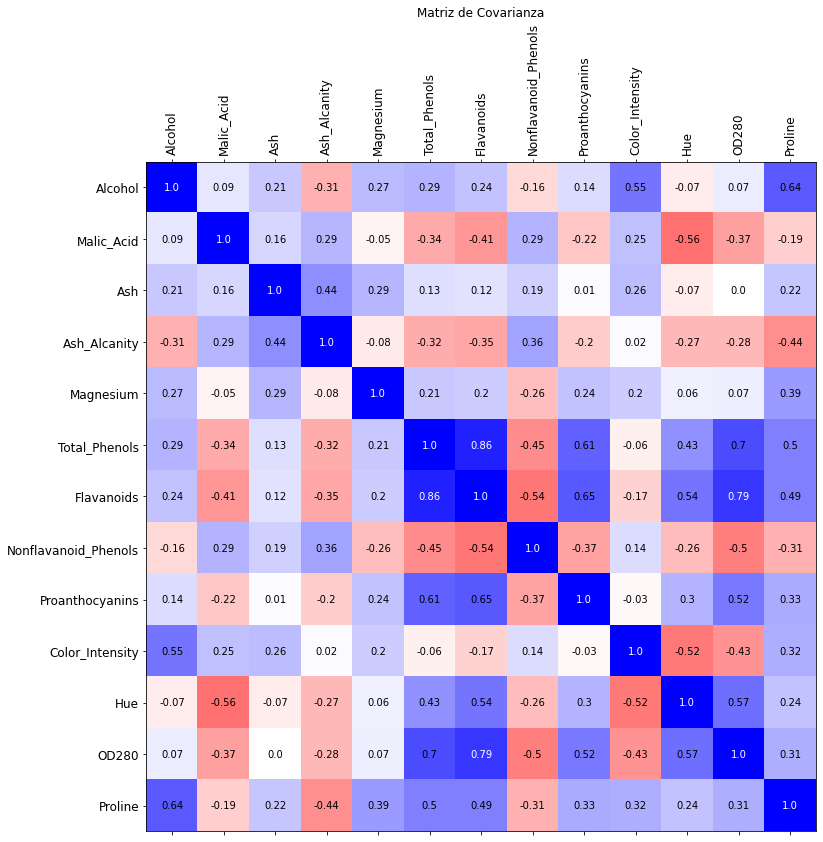

In [17]:
plt.matshow(XTX, cmap='bwr_r', vmin=-1, vmax=1)

for i in range(XTX.shape[0]):
    for j in range(XTX.shape[1]):
        # Valores de la matriz de covarianza
        plt.text(i, j, str(XTX[i, j].round(2)), va='center', ha='center',
                 color='white' if XTX[i, j] > 0.7 else 'black')

# Agrego categorías a los ejes directamente desde el dataframe original
plt.xticks(range(XTX.shape[0]), data.columns[0:num_indep], rotation=90, fontsize=12)
plt.yticks(range(XTX.shape[1]), data.columns[0:num_indep], fontsize=12)
plt.title('Matriz de Covarianza')
plt.show()

Viendo las mayores intensidades de color azul o rojo podemos encontrar las variables más interrelacionadas, como son `Malic_Acid` con `Hue` de forma negativa o `proline` con `alcohol` de forma positiva.

De esta manera, uno podría asumir que si `proline` es alto entonces `alcohol` también, por lo que podríamos quedarnos solo con la variable `proline` y tener **casi** la misma información. Ésta es la idea detrás de tomar autovalores de la matriz de covarianza y cómo a partir de combinar la información de distintas variables se puede resumir gran parte de esa información en una única variable nueva. 

### $\text{(e)}$ Máximo autovalor y Método de la Potencia

Definimos la función `encontrar_max_autovalor` que devuelve el máximo autovalor y su correspondiente autovector utilizando el método de la potencia.

Por seguridad, se configuró una máxima cantidad de iteraciones a realizar, en caso de que no haya convergencia (imposible para los datos de este TP por tener columnas li., pero generalizando para otros casos).

In [18]:
def encontrar_max_autovalor(X, tol = 1e-6, max_iter = 10_000):
    """
    Dada una matriz X y una tolerancia, devuelve el autovalor más grande y su autovector asociado
    utilizando el método de la potencia.

    Parameters:
    - X (numpy.ndarray): Matriz para encontrar el autovalor.
    - tol (float): Tolerancia para la convergencia del método.
    - max_iter (int): Número máximo de iteraciones.

    Returns:
    - aval (float): Autovalor más grande.
    - x (numpy.ndarray): Autovector asociado al autovalor más grande.
    """
    
    max_iter = 10_000

    n = X.shape[0]
    x = np.ones(n)/np.sqrt(n)
    x = x / np.linalg.norm(x)
    x_old = np.zeros_like(x)
    i = 0
    while np.linalg.norm(x - x_old) > tol and i < max_iter:
        x_old = x
        x = X.dot(x)
        x = x / np.linalg.norm(x)
        i += 1

    if i == max_iter:
        print(f"Advertencia: El autovalor no convergió! Iteraciones realizadas: {i}")

    aval = x.T.dot(X.dot(x))
    return aval, x


In [19]:
max_aval, max_avec = encontrar_max_autovalor(XTX)

print(f"Autovalor máximo: {max_aval.round(6)}")
print(f"Autovector asociado:\n{max_avec.round(4)}")

Autovalor máximo: 4.70585
Autovector asociado:
[ 0.1443 -0.2452 -0.0021 -0.2393  0.142   0.3947  0.4229 -0.2985  0.3134
 -0.0886  0.2967  0.3762  0.2868]


In [20]:
autovalores, autovectores = np.linalg.eig(XTX)
print(f"Autovalor máximo calculado con Numpy: {autovalores[0].round(6)}")
print(f"Autovector correspondiente:\n{autovectores[:, 0].round(4)}")

Autovalor máximo calculado con Numpy: 4.70585
Autovector correspondiente:
[-0.1443  0.2452  0.0021  0.2393 -0.142  -0.3947 -0.4229  0.2985 -0.3134
  0.0886 -0.2967 -0.3762 -0.2868]


En el siguiente punto verificaremos que todos los autovalores y autovectores calculados con el método de la potencia sean bien cercanos a los valores devueltos por Numpy.

### $\text{(f)}$ Autovalores sucesivos y sus autovectores

Dado que nuestros datos poseen 13 columnas de variables independientes (y linealmente independiente), y que ninguna de sus filas es combinación lineal de otras, el rango de la matriz $X$ será de la menor de las dimensiones entre filas y columnas, en nuestro caso, 13 columnas.

Por lo tanto, la matriz de covarianza que surge de hacer $X^t X$ tendrá todos sus autovalores positivos, que serán 13 (si alguno fuera cero, entonces deberían existir columnas o filas linealmente dependientes entre ellas).

Cada uno de los 13 autovalores de $X^t X$ es a su vez cada uno de los **valores principales** de $X$, el cual nos indica la "intensidad" o "peso" que tiene el autovector asociado correspondiente como dirección hacia donde mayor varianza tienen los datos.

Dicho de otra forma, cada uno de estos autovalores y autovectores asociado "resume" la información que se encuentra en los datos $X$, de forma que el primer valor principal y el autovector asociado nos dará la máxima información posible en una única dimensión, mientras que el segundo valor principal y el autovector asociado nos dará la segunda-máxima información posible en una dirección ortogonal al primer vector. Así sucesivamente hasta recorrer los 13 valores principales y sus correspondientes autovectores, los cuales, en todo su conjunto, nos dan exactamente toda la información que aparece en $X$.

Un detalle importante es que, así como los valores principales se ordenan de mayor a menor en la matriz diagonal $\Sigma$ en una descomposición SVD, tendremos ordenados por "importancia" los valores principales y autovectores que mejor resumen nuestros datos en $X$.

### Algoritmo

Para implementar el algoritmo que calcula todos los autovalores y autovectores de una matriz en órden descendente, usaremos la función `encontrar_max_autovalor` definida anteriormente.

Una vez encontrado el primer autovalor $\sigma_1$ y su correspondiente autovector $v_1$, restaremos a la matriz original el producto: $\sigma_1 \langle v_1, v_1 \rangle$

De esta forma obtendremos una nueva matriz cuyo autovalor máximo será el segundo autovalor más grande de la matriz original, con su correspondiente autovector:

$$X^t X = U \Sigma V^t $$

Como $X^t X$ es simétrica:

$$X^t X = V \Sigma V^t $$

Que podemos reescribir de forma reducida como:

$$X^t X = \sigma_1 \langle v_1, v_1 \rangle + \sigma_2 \langle v_2, v_2 \rangle + \dots + \sigma_{13} \langle v_{13}, v_{13} \rangle$$

Luego de encontrar el primer autovalor y autovector de $X^t X$, restamos a la matriz original:

$$X^t X - \sigma_1 \langle v_1, v_1 \rangle= \sigma_1 \langle v_1, v_1 \rangle + \sigma_2 \langle v_2, v_2 \rangle + \dots + \sigma_{13} \langle v_{13}, v_{13} \rangle - \sigma_1 \langle v_1, v_1 \rangle$$

$$X^t X - \sigma_1 \langle v_1, v_1 \rangle= \sigma_1 \langle v_1, v_1 \rangle - \sigma_1 \langle v_1, v_1 \rangle + \sigma_2 \langle v_2, v_2 \rangle + \dots + \sigma_{13} \langle v_{13}, v_{13}\rangle $$

$$A_{-1}= \sigma_2 \langle v_2, v_2 \rangle + \dots + \sigma_{13} \langle v_{13}, v_{13} \rangle - \sigma_1 \langle v_1, v_1 \rangle$$

La nueva matriz $A_{-1}$ tendrá todas las componentes de rango 1 que $X^t X$ menos la primera, por lo que su máximo autovalor y autovector correspondiente se corresponderá con el segundo máximo de la matriz $X^t X$ inicial.

De manera iterativa podemos encontrar cada uno de los autovalores y autovectores de la matriz original en orden descendente.


In [21]:
def encontrar_autovalores(X, n, tol=1e-8):
    """
    Dada una matriz X y un número n, devuelve los n autovalores más grandes y sus autovectores asociados
    utilizando el método de la potencia.

    Parameters:
    - X (numpy.ndarray): Matriz para encontrar los autovalores.
    - n (int): Número de autovalores a calcular.
    - tol (float): Tolerancia para la convergencia del método.

    Returns:
    - autovalores (numpy.ndarray): Array con los n autovalores más grandes.
    - autovectores (numpy.ndarray): Matriz cuyas columnas son los autovectores asociados a los autovalores.
    """
    
    autovalores = np.zeros(n)
    autovectores = np.zeros((X.shape[0], n))
    nuevaX = X.copy()

    for i in range(n):
        aval, avec = encontrar_max_autovalor(nuevaX, tol)
        autovalores[i] = aval
        autovectores[:, i] = avec
        nuevaX = nuevaX - aval * np.outer(avec, avec)
        
    return autovalores, autovectores

Verificamos que todos los autovalores y autovectores calculados con `encontrar_autovalores` sean iguales a `np.linalg.eig()` de Numpy:

In [22]:
def test_autovalores(X):
    """
    Prueba la función de encontrar_autovalores comparando sus resultados con la función np.linalg.eig.

    Parameters:
    - X (numpy.ndarray): Matriz de datos.

    Returns:
    - resultado (bool): True si los autovalores y autovectores son similares a los de Numpy, False en caso contrario.
    """
    n = X.shape[0]
    autovalores, autovectores = encontrar_autovalores(X, n)
    autovalores_np, autovectores_np = np.linalg.eig(X)

    # Ordeno los autovalores y autovectores de mayor a menor
    idx = np.argsort(autovalores_np)[::-1]
    autovalores_np = autovalores_np[idx]
    autovectores_np = autovectores_np[:, idx]

    autovalores_similares = np.allclose(autovalores, autovalores_np)

    # Los autovectores pueden tener signo opuesto, por lo que no es posible compararlos directamente
    autovectores_similares = True
    for v in autovectores:
        if (v not in autovectores) and (-v not in autovectores):
            autovectores_similares = False
            break

    print(f"Autovalores similares a Numpy: {autovalores_similares}")
    print(f"Autovectores similares a Numpy: {autovectores_similares}")
    return autovalores_similares and autovectores_similares

test_autovalores(XTX)

Autovalores similares a Numpy: True
Autovectores similares a Numpy: True


True

### $\text{(g)}$ Método de PCA y KNN

Para utilizar el método de PCA (*Principal Component Analisys*) necesitamos obtener los primeros $n$ componentes principales de la matriz de covarianza de los datos estandarizados, es decir, sus $n$ autovectores más grandes.

Una vez obtenido estos valores, podemos usar el algoritmo KNN sobre los datos proyectados en una dimensionalidad menor para clasificarlos utilizando solamente una porción del espacio utilizado por los datos de entrenamiento.

In [23]:
def calcular_pca(X, n=2):
    """
    Dado un conjunto de datos X y un número n, devuelve los n autovalores más grandes y sus autovectores asociados.

    Parameters:
    - X (numpy.ndarray): Matriz de datos.
    - n (int): Número de componentes principales a calcular.

    Returns:
    - autovalores (numpy.ndarray): Array con los n autovalores más grandes.
    - autovectores (numpy.ndarray): Matriz cuyas columnas son los autovectores asociados a los autovalores.
    """
    XTX = matriz_covarianza(X)
    autovalores, autovectores = encontrar_autovalores(XTX, n)
    return autovalores, autovectores

In [24]:
def proyectar_datos(X, W):
    """
    Dado un conjunto de datos X y una matriz de proyección W, devuelve los datos transformados.

    Parameters:
    - X (numpy.ndarray): Matriz de datos a proyectar.
    - W (numpy.ndarray): Matriz de proyección.

    Returns:
    - X_proyectado (numpy.ndarray): Matriz de datos transformados.
    """
    return X.dot(W)

In [25]:
def knn(X, y, x_new, k=3):
    """
    Dado un conjunto de datos X, sus etiquetas y un punto x, devuelve la clase a la que pertenece x
    utilizando el algoritmo KNN con k vecinos.

    Parameters:
    - X (numpy.ndarray): Conjunto de datos de entrenamiento.
    - y (numpy.ndarray): Etiquetas correspondientes a los datos de entrenamiento.
    - x_new (numpy.ndarray): Nuevo punto para clasificar.
    - k (int): Número de vecinos a considerar.

    Returns:
    - max_clase (int): Clase predicha para el punto x_new.
    """
    # Calculamos las distancias como norma 2 entre todos los puntos y el punto x
    distancias = np.linalg.norm(X - x_new, axis=1, ord=2)

    # Ordenamos las distancias de menor a mayor y nos quedamos con los índices
    indices = np.argsort(distancias)

    # Ordenamos las clases y nos quedamos con las k primeras
    clases = y[indices][:k]

    # Contamos cuántas veces aparece cada clase
    # Ignoramos la clase 0 que no existe pero que es parte de bincount
    cantidades = np.bincount(clases, minlength=4)

    # Nos quedamos con la clase que más aparece
    max_clase = np.argmax(cantidades)
    return max_clase

### Visualización de prueba de PCA y KNN

A continuación, una prueba de testeo de las tres funciones definidas anteriormente:

1. `calcular_pca` que dada una matriz $X$ devuelve una matriz $W$ con sus $n$ componentes principales como columnas.
2. `proyectar_datos` que dada una matriz de datos $X$ y una matriz de proyección $W$ (obtenida a partir de `calcular_pca`) devuelve las coordenadas de $X$ en el subespacio definido por $W$.
3. `knn` que dada una matriz de datos $X$, sus etiquetas $y$ y un nuevo punto $x_{new}$ devuelve la clase a la que perteneces este punto.

La función `test_pca` calculará los componentes principales de **la totalidad** de los datos $X$ y los proyectará sobre el subespacio generado por los primeros $n$ autovectores de $X^t X$ (las primeras $n$ componentes principales de $X$).

Luego se generará una grilla de puntos que se categorizarán usando la función `knn`.

De esta manera tendremos las coordenadas de los datos del dataset proyectados como puntos en el plano de 2 dimensiones (2 componentes principales) y también las zonas de decisión de ese espacio coloreadas por categoría a la cual pertenecen.

In [26]:
def test_pca(X, y, k=5):
    """
    Dado un conjunto de datos X y sus etiquetas, devuelve un gráfico de dispersión de los datos
    proyectados en los n autovectores más grandes.

    Parameters:
    - X (numpy.ndarray): Conjunto de datos de entrenamiento.
    - y (numpy.ndarray): Etiquetas correspondientes a los datos de entrenamiento.
    - k (int): Número de vecinos a considerar en el algoritmo KNN.

    Returns:
    - None
    """
    n = 2 # Número de componentes principales (fijo)

    avals, avecs = calcular_pca(X, n)
    X_pca = proyectar_datos(X, avecs)

    # Grilla de puntos para graficar las zonas de decisión
    x1 = np.linspace(-4.5, 4.5, 200)
    x2 = np.linspace(-4.5, 4.5, 200)
    xx1, xx2 = np.meshgrid(x1, x2)

    xx = np.array([xx1.flatten(), xx2.flatten()]).T
    yy = np.array([knn(X_pca, y, x, k) for x in xx])
    yy = yy.reshape(xx1.shape)

    cmap = ListedColormap(['blue', 'red', 'green'])

    plt.contourf(xx1, xx2, yy, cmap=cmap, alpha=0.4, vmin=1, vmax=3)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, label='Datos proyectados', edgecolors='k')

    # ScalarMappable para visualizar la barra de colores lateral
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ticks=[1, 2, 3], label='Clase', boundaries=[0.5, 1.5, 2.5, 3.5])
    
    plt.title(f'PCA con {n} componentes principales y zonas de decisión de KNN con k={k}')
    plt.legend()
    plt.show()

El primer ejemplo de test es con $k=1$ para `knn`, donde se observan "agujeros" en regiones por puntos de alguna categoria rodeados de alguna otra:


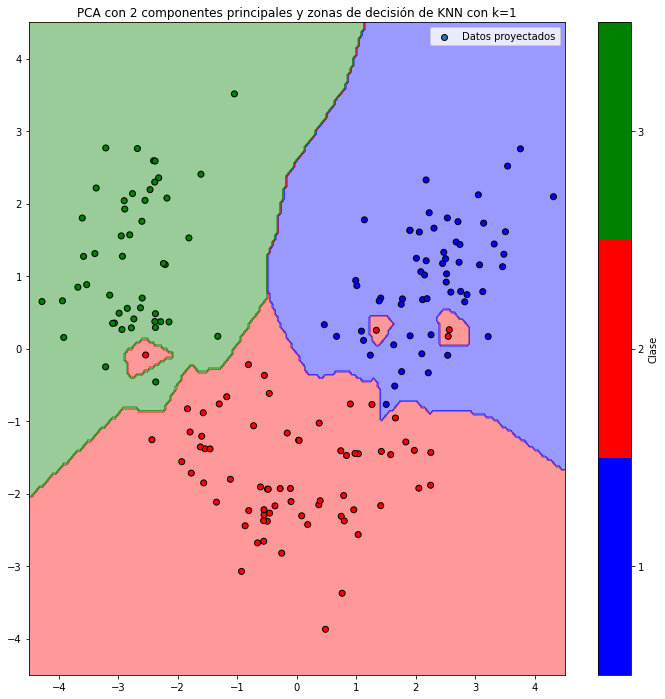

In [27]:
test_pca(X, y, k=1)

Con $k=5$ podemos ver que estos "agujeros" desaparecen como es de esperar, ya que al tomar en cuenta varios vecinos, los datos aislados son descartados en estas decisiones:

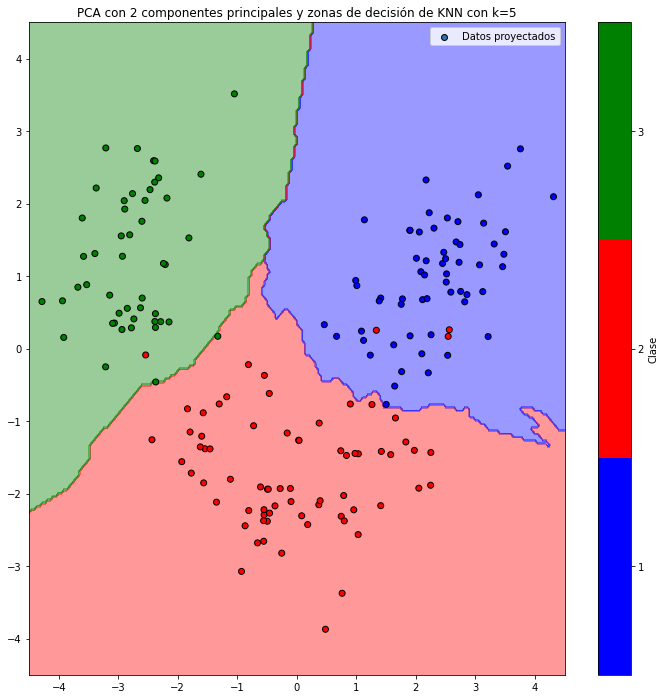

In [28]:
test_pca(X, y, k=5)

### $\text{(g)}$ Función de Clasificación

Finalmente definimos la función que se encargará de clasificar un nuevo punto $x_i$ a partir de un conjunto de datos estandarizados $X_{train}$

In [29]:
def clasificar_pca(xi, X_train_pca, y_train, X_mean, X_std, W_pca, k=5):
    """
    Dado un punto xi, las componentes principales de un conjunto de entrenamiento estandarizado X_train_pca,
    sus etiquetas y_train, la media y desviación estándar de X_train original, n componentes principales en W_pca
    y un número k de vecinos, devuelve la tupla (xi_pca, yi) donde xi_pca es la proyección de xi en los n componentes
    principales y yi es la clase a la que pertenece.

    Parameters:
    - xi (numpy.ndarray): Punto a clasificar.
    - X_train_pca (numpy.ndarray): Componentes principales del conjunto de entrenamiento.
    - y_train (numpy.ndarray): Etiquetas correspondientes al conjunto de entrenamiento.
    - X_mean (numpy.ndarray): Media del conjunto de entrenamiento original.
    - X_std (numpy.ndarray): Desviación estándar del conjunto de entrenamiento original.
    - W_pca (numpy.ndarray): Matriz de proyección de PCA.
    - k (int): Número de vecinos a considerar en el algoritmo KNN.

    Returns:
    - (xi_pca, yi) (tuple): Tupla donde xi_pca es la proyección de xi en los n componentes principales y yi es la
      clase a la que pertenece.
    """
    # Normalizamos el punto xi a partir de la media y desviación estándar de X_train
    xi_norm = (xi - X_mean) / X_std

    # Calculamos los n componentes principales
    xi_pca = proyectar_datos(xi_norm, W_pca)

    # Clasificamos utilizando KNN
    yi = knn(X_train_pca, y_train, xi_pca, k)
    return xi_pca, yi

# Ejercicio 2

### Datos originales

Primero necesitamos volver a los datos originales sin estandarizar, ya que no queremos que haya ningún tipo de filtración de información desde los datos de testeo hacia entrenamiento.

Para eso primero separamos los datos en datos de entrenamiento y de testeo, para luego estandarizarlos solo usando la media y desviación estándar de los datos de entrenamiento.



In [30]:
# Construyo matrices de datos sin estandarizar
num_indep = data.shape[1] - 1
X = data.iloc[:, 0:num_indep].values
y = data.iloc[:, -1].values

### División de los datos

Dividimos los datos en datos de entrenamiento $X_{train}, y_{train}$ y datos de testeo $X_{test}, y_{test}$.

Para eso elegiremos un $80 \%$ de los datos al azar como entrenamiento y el restante $20\%$ como testeo.

In [31]:
def dividir_dataset(X, y, p=0.8):
    """
    Dado un conjunto de datos X y sus etiquetas, devuelve dos conjuntos de datos y etiquetas de entrenamiento y testeo.

    Parameters:
    - X (numpy.ndarray): Conjunto de datos.
    - y (numpy.ndarray): Etiquetas correspondientes a los datos.
    - p (float): Proporción de datos a utilizar para entrenamiento (por defecto, 0.8).

    Returns:
    - X_train (numpy.ndarray): Conjunto de datos de entrenamiento.
    - y_train (numpy.ndarray): Etiquetas correspondientes al conjunto de entrenamiento.
    - X_test (numpy.ndarray): Conjunto de datos de testeo.
    - y_test (numpy.ndarray): Etiquetas correspondientes al conjunto de testeo.
    """
    n = X.shape[0]
    rand_idx = np.random.permutation(n)
    n_train = int(n * p)

    train_idx = rand_idx[:n_train]
    test_idx = rand_idx[n_train:]

    X_train = X[train_idx, :]
    y_train = y[train_idx]

    X_test = X[test_idx, :]
    y_test = y[test_idx]

    return X_train, y_train, X_test, y_test


Verificamos que las dimensiones de las matrices devueltas por la función `dividir_dataset` estén en orden:

In [32]:
X_train, y_train, X_test, y_test = dividir_dataset(X, y)

print(f"Datos totales: {X.shape[0]}")
print(f"Proporción de datos de entrenamiento: {round(X_train.shape[0] / X.shape[0], 2)}")
print()
print(f"Dimensionalidad de X_train: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"Dimensionalidad de y_train: {y_train.shape[0]}")
print(f"Dimensionalidad de X_test: {X_test.shape[0]} x {X_test.shape[1]}")
print(f"Dimensionalidad de y_test: {y_test.shape[0]}")

Datos totales: 178
Proporción de datos de entrenamiento: 0.8

Dimensionalidad de X_train: 142 x 13
Dimensionalidad de y_train: 142
Dimensionalidad de X_test: 36 x 13
Dimensionalidad de y_test: 36


Estandarizamos **solo** los datos de entrenamiento y guardamos media $X_{mean}$ y desviación estándar $X_{std}$ originales para poder estandarizar nuevos puntos $x_i$ bajo la distribución de los datos de entrenamiento $X_{train}$

In [33]:
X_train, X_mean, X_std = normalizar_datos(X_train)
# Nota: Los datos de testeo se estandarizan dentro de la función clasificar_pca

In [34]:
def ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n=2, k=10):
    """
    Ejecuta un modelo que clasifica puntos en el conjunto de prueba X_test utilizando PCA y KNN.

    Parameters:
    - X_test (numpy.ndarray): Conjunto de datos de prueba.
    - X_train_pca (numpy.ndarray): Componentes principales del conjunto de entrenamiento.
    - y_train (numpy.ndarray): Etiquetas correspondientes al conjunto de entrenamiento.
    - W_pca (numpy.ndarray): Matriz de proyección de PCA.
    - X_mean (numpy.ndarray): Media del conjunto de entrenamiento original.
    - X_std (numpy.ndarray): Desviación estándar del conjunto de entrenamiento original.
    - n (int): Número de componentes principales (por defecto, 2).
    - k (int): Número de vecinos a considerar en el algoritmo KNN (por defecto, 10).

    Returns:
    - X_test_pca (numpy.ndarray): Conjunto de datos de prueba proyectado en los n componentes principales.
    - y_pred (numpy.ndarray): Etiquetas predichas para el conjunto de prueba.
    """
    num_test = X_test.shape[0]
    X_test_pca = np.zeros((num_test, n))
    y_pred = np.zeros_like(y_test)

    for i in range(num_test):
        xi_pca, yi =  clasificar_pca(X_test[i], X_train_pca, y_train, X_mean, X_std, W_pca, k)
        X_test_pca[i, :] = xi_pca
        y_pred[i] = yi

    return X_test_pca, y_pred

In [35]:
def test_modelo(X_train, X_test, y_train, y_test, n=2, k=10):
    """
    Realiza pruebas de un modelo que utiliza PCA y KNN para clasificar datos de prueba.

    Parameters:
    - X_train (numpy.ndarray): Conjunto de datos de entrenamiento.
    - X_test (numpy.ndarray): Conjunto de datos de prueba.
    - y_train (numpy.ndarray): Etiquetas correspondientes al conjunto de entrenamiento.
    - y_test (numpy.ndarray): Etiquetas correspondientes al conjunto de prueba.
    - n (int): Número de componentes principales para PCA (por defecto, 2).
    - k (int): Número de vecinos a considerar en el algoritmo KNN (por defecto, 10).

    Returns:
    - None
    """
    # Calculo los autovalores y autovectores utilizando PCA
    _, W_pca = calcular_pca(X_train, n)

    # Proyecto los datos de entrenamiento y testeo sobre las componentes principales obtenidas
    X_train_pca = proyectar_datos(X_train, W_pca)

    # Ejecuto el modelo en el conjunto de prueba
    _, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)
    
    # Calculo el número de predicciones correctas e incorrectas
    num_correct = sum(y_pred == y_test)
    num_incorrect = sum(y_pred != y_test)

    print(f"Número de predicciones correctas: {num_correct}")
    print(f"Número de predicciones incorrectas: {num_incorrect}")
    print(f"Precisión: {num_correct / (num_correct + num_incorrect)}")

test_modelo(X_train, X_test, y_train, y_test, n=2, k=10)

Número de predicciones correctas: 33
Número de predicciones incorrectas: 3
Precisión: 0.9166666666666666


Como `num_correct` y `num_incorrect` suman la cantidad total de datos de testeo, por lo que solo basta calcular uno y tener la cantidad de datos de test para obtener el valor del otro.

De ahora en más, solo calcularemos `num_incorrect` como medida de evaluación del modelo.

### Búsqueda de los mejores parámetros

Una vez que tenemos la función que ejecuta un modelo para algún conjunto de parámetros particulares, podemos iterar sobre varios parámetros para recorrer el espacio de soluciones de, por ejemplo, valores principales entre 1 y 4 incluidos.

In [36]:
for n in range(1, 5):
    _, W_pca = calcular_pca(X_train, n)
    X_train_pca = proyectar_datos(X_train, W_pca)
    
    _, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k=10)
    num_incorrect = sum(y_pred != y_test)
    print(f"Componentes Principales = {n}: Número de predicciones incorrectas: {num_incorrect}")


Componentes Principales = 1: Número de predicciones incorrectas: 9
Componentes Principales = 2: Número de predicciones incorrectas: 3
Componentes Principales = 3: Número de predicciones incorrectas: 0
Componentes Principales = 4: Número de predicciones incorrectas: 0


Podemos ver que (para esta separación de `train` y `test` particular) el número de predicciones incorrectas decrecen con la cantidad de componentes principales, como es de esperarse.

Pero todavía tenemos un segundo parámetro a explorar dado por el algoritmo de vecinos más cercanos KNN:

In [37]:
def obtener_estadisticas(X_train, X_test, y_train, y_test, X_mean, X_std, num_componentes, vecinos):
    """
    Obtiene estadísticas de clasificación para diferentes números de componentes principales y vecinos en KNN.

    Parameters:
    - X_train (numpy.ndarray): Conjunto de datos de entrenamiento.
    - X_test (numpy.ndarray): Conjunto de datos de prueba.
    - y_train (numpy.ndarray): Etiquetas correspondientes al conjunto de entrenamiento.
    - y_test (numpy.ndarray): Etiquetas correspondientes al conjunto de prueba.
    - X_mean (numpy.ndarray): Media del conjunto de entrenamiento original.
    - X_std (numpy.ndarray): Desviación estándar del conjunto de entrenamiento original.
    - num_componentes (list): Lista de números de componentes principales a probar.
    - vecinos (list): Lista de números de vecinos a probar en KNN.

    Returns:
    - estadisticas (numpy.ndarray): Matriz de estadísticas de clasificación.
    """
    m = len(num_componentes)
    tot_vecinos = len(vecinos)
    estadisticas = np.zeros((m, tot_vecinos))

    for n in range(1, m+1):
        _, W_pca = calcular_pca(X_train, n)
        X_train_pca = proyectar_datos(X_train, W_pca)
        for k in range(1, tot_vecinos+1):
            _, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)
            num_incorrect = sum(y_pred != y_test)
            estadisticas[n-1, k-1] = num_incorrect

    return estadisticas

In [38]:
num_componentes = range(1, 5)
vecinos = range(1, 41)
estadisticas = obtener_estadisticas(X_train, X_test, y_train, y_test, X_mean, X_std, num_componentes, vecinos)

print("Finalizado. Estadísticas obtenidas.")

Finalizado. Estadísticas obtenidas.


En este caso optamos por graficar en una tabla coloreada las distintas cantidades de errores según la combinación de parámetros.

Nota: Para los vecinos elegimos entre 1 y 40 ya que buscábamos no solo que baje el error, sino que vuelva a aumentar, de forma que quede explícito que valores más grande de vecinos **no siempre** resulta en un mejor modelo.

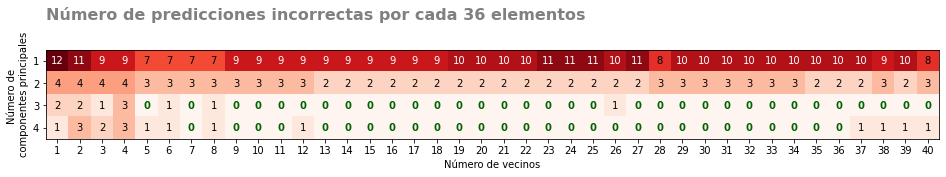

In [39]:
def colorear_error(e):
    """
    Asigna un color en función del número de errores.

    Parameters:
    - e (int): Número de errores.

    Returns:
    - str: Color correspondiente.
    """
    if e == 0:
        return 'darkgreen'
    elif e <= 8:
        return 'black'
    else:
        return 'white'

# Creo un gráfico de matriz mostrando las estadísticas de clasificación
plt.matshow(estadisticas, cmap='Reds', vmin=0, vmax=estadisticas.max())

for i in range(estadisticas.shape[0]):
    for j in range(estadisticas.shape[1]):
        plt.text(j, i, f'{int(estadisticas[i, j])}', va='center', ha='center',
                 color=colorear_error(estadisticas[i, j]),
                 fontweight='bold' if estadisticas[i, j] == 0 else 'normal')

# Ajusto parámetros de las etiquetas en los ejes
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

# Etiquetas en los ejes x e y
plt.xticks(range(estadisticas.shape[1]), labels=vecinos)
plt.yticks(range(estadisticas.shape[0]), labels=num_componentes)

plt.title(f'Número de predicciones incorrectas por cada {X_test.shape[0]} elementos', pad=30, fontsize=16, fontweight='bold', color='gray', loc='left')
plt.xlabel('Número de vecinos')
plt.ylabel('Número de \ncomponentes principales')
plt.show()


Analisis preliminar:

* En la tabla anterior podemos ver cómo para una sola componente principal, la cantidad de errores es bastante alta (entre 7 y 12), pero dentro de esta variedad de valores altos, podemos encontrar valores menos altos que otros dependiendo de la cantidad de vecinos, como son los valores entre 5 y 8.

* Usando 2 componentes principales podemos ver que el error se reduce aproximadamente a una tercera parte. En este caso vemos que la cantidad de vecinos cercanos debe ser mayor para obtener la menor cantidad de errores, aunque este rango se mantiene de manera más estable (valores de k entre 13 y 27, y hasta algunos más altos).

* Con 3 y 4 componentes principales vemos los mejores resultados: Ningún error para la mayoria de los vecinos mayores 8 y algunos otros aislados de menor k.

Aunque este análisis es simple e fácilmente interpretable, existe el problema de que depende de cómo separamos los datos.

### Generalizando Resultados

El analisis anterior puede depender en gran medida de la forma en que separamos los datos de entrenamiento y testeo.

Por eso debemos repetir los experimentos anteriores, pero tomando distintos subconjuntos de datos de entrenamiento y testeo en cada iteración.

Juntamos todo en la siguiente función:

In [40]:
def analisis_completo(iteraciones=100):
    """
    Realiza un análisis completo de clasificación con PCA y KNN sobre múltiples iteraciones.

    Parameters:
    - iteraciones (int): Número de iteraciones para realizar el análisis completo (por defecto, 100).

    Returns:
    - estadisticas (numpy.ndarray): Matriz de estadísticas de clasificación promediadas.
    """
    num_componentes = range(1, 5)
    vecinos = range(1, 41)
    
    sum_estadisticas = np.zeros((len(num_componentes), len(vecinos)))
    
    for i in tqdm(range(iteraciones)):
        X_train, y_train, X_test, y_test = dividir_dataset(X, y)
        X_train, X_mean, X_std = normalizar_datos(X_train)

        estadisticas = obtener_estadisticas(X_train, X_test, y_train, y_test, X_mean, X_std, num_componentes, vecinos)
        sum_estadisticas += estadisticas

    estadisticas = sum_estadisticas / iteraciones

    return estadisticas

In [41]:
iteraciones = 100
estadisticas = analisis_completo(iteraciones)


 13%|█▎        | 13/100 [00:04<00:32,  2.68it/s]

100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Nuevamente volvemos a graficar los valores de error, pero ahora como un promedio varias iteraciones de pruebas con distintos subconjuntos de datos en cada uno:

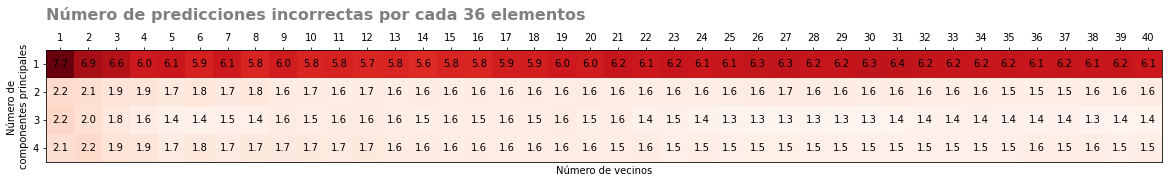

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))

cax = ax.matshow(estadisticas, cmap='Reds', vmin=estadisticas.min(), vmax=estadisticas.max())

for i in range(estadisticas.shape[0]):
    for j in range(estadisticas.shape[1]):
        ax.text(j, i, estadisticas[i, j].round(1), va='center', ha='center',
                color=colorear_error(estadisticas[i, j]))

ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

ax.set_xticks(range(estadisticas.shape[1]))
ax.set_yticks(range(estadisticas.shape[0]))
ax.set_xticklabels(vecinos)
ax.set_yticklabels(num_componentes)

ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.title(f'Número de predicciones incorrectas por cada {X_test.shape[0]} elementos', pad=30, fontsize=16, fontweight='bold', color='gray', loc='left')
plt.xlabel('Número de vecinos')
plt.ylabel('Número de \ncomponentes principales')
plt.show()


Viendo la tabla anterior, podemos observar que la distribución de resultados es mucho más suave para una misma componente principal.

Por un lado ya no existe modelo entre los propuestos que devuelva una performance perfecta (sin errores).

Por el otro, vemos una gran diferencia de performance entre usar una sola componente principal o usar más de una. Pero no así entre 2 y 4 componentes principales, que muestran resultados muy parecidos.

Los mejores valores de vecinos más cercanos se encuentran entre 4 y 12 vecinos, aunque para 3 componentes principales el error baja ligeramente para 25-30 vecinos.

De esta manera obtuvimos resultados más robustos que indican que usar 1 sola componente principal es insuficiente, usar 2 o más es recomendable, pero usar 4 no mejora los resultados para los vecinos analizados.

Dados estos resultados, podemos decir que de tener que elegir una cantidad de componentes principales, lo mejor sería usar 3 con 5 o 6 vecinos, con la aclaración que usando solo 2 componentes principales la performance no baja tanto, por lo que si se busca minimizar el tamaño de las matrices involucradas en el proceso, ésta puede ser una mejor opción. 

En general la precisión se define como un porcentaje del total de elementos, por lo que la tabla en una forma estándar sería:

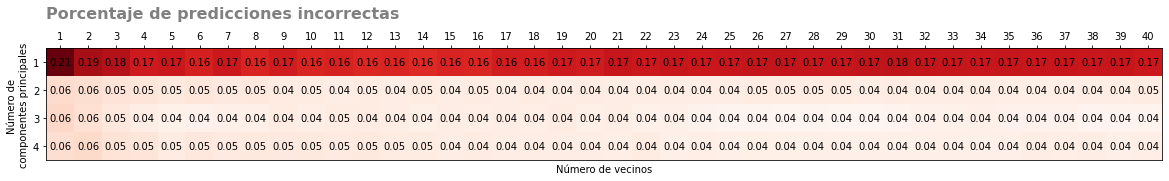

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))

cax = ax.matshow(estadisticas, cmap='Reds', vmin=estadisticas.min(), vmax=estadisticas.max())

for i in range(estadisticas.shape[0]):
    for j in range(estadisticas.shape[1]):
        ax.text(j, i, (estadisticas[i, j] / X_test.shape[0]).round(2), va='center', ha='center',
                color=colorear_error(estadisticas[i, j]))

ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

ax.set_xticks(range(estadisticas.shape[1]))
ax.set_yticks(range(estadisticas.shape[0]))
ax.set_xticklabels(vecinos)
ax.set_yticklabels(num_componentes)

ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)

plt.title(f'Porcentaje de predicciones incorrectas', pad=30, fontsize=16, fontweight='bold', color='gray', loc='left')
plt.xlabel('Número de vecinos')
plt.ylabel('Número de \ncomponentes principales')
plt.show()

Posteriormente seguiremos usando la medida de *"errores por cada 36 elementos"* ya que es más fácil de interpretar para el caso particular de este TP con un número fijo de cantidades de test.

### Comparando resultados con Varianza Explicada

A partir de la varianza explicada de una matriz de covarianza, podemos estimar la cantidad de información contenida en esa componente.

Siguiendo con el análisis de los datos separados en datos de entrenamiento y testeo, calcularemos la varianza explicada usando solo datos de entrenamiento como también los datos totales.

De la misma forma que antes, eligiendo distintos subconjuntos de entrenamiento vamos a estar obteniendo distintos valores de varianza explicada, pues por cada set de datos de entrenamiento la matriz de covarianza $X^t X$ (que en realidad es $X^t_{train} X_{train}$) es diferente.

Por lo tanto podemos repetir el experimento y promediar los resultados de los autovalores obtenidos.

In [44]:
def promediar_autovalores(X, iteraciones=100):
    """
    Calcula el promedio de los autovalores de la matriz de covarianza para un conjunto de datos X.

    Parameters:
    - X (numpy.ndarray): Conjunto de datos.
    - iteraciones (int): Número de iteraciones para realizar el promedio (por defecto, 100).

    Returns:
    - autovalores (numpy.ndarray): Promedio de los autovalores.
    """
    m = X.shape[1]
    sum_autovalores = np.zeros(m)

    for i in tqdm(range(iteraciones)):
        X_train, y_train, X_test, y_test = dividir_dataset(X, y)
        X_train, X_mean, X_std = normalizar_datos(X_train)

        XTX = matriz_covarianza(X_train)
        autovalores, _ = encontrar_autovalores(XTX, m)

        sum_autovalores += autovalores

    autovalores = sum_autovalores / iteraciones

    return autovalores

In [45]:
autovalores = promediar_autovalores(X)

100%|██████████| 100/100 [00:03<00:00, 29.26it/s]


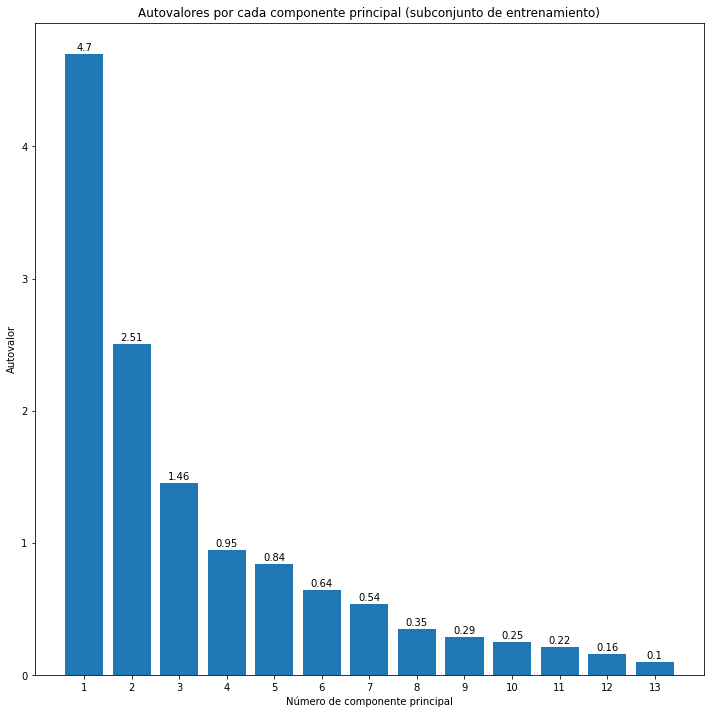

In [46]:
plt.bar(range(1, len(autovalores)+1), autovalores)
for i, v in enumerate(autovalores):
    plt.text(i+1, v+0.01, str(round(v, 2)), ha='center', va='bottom')
plt.title('Autovalores por cada componente principal (subconjunto de entrenamiento)')
plt.xlabel('Número de componente principal')
plt.ylabel('Autovalor')
plt.xticks(range(1, len(autovalores)+1))
plt.show()

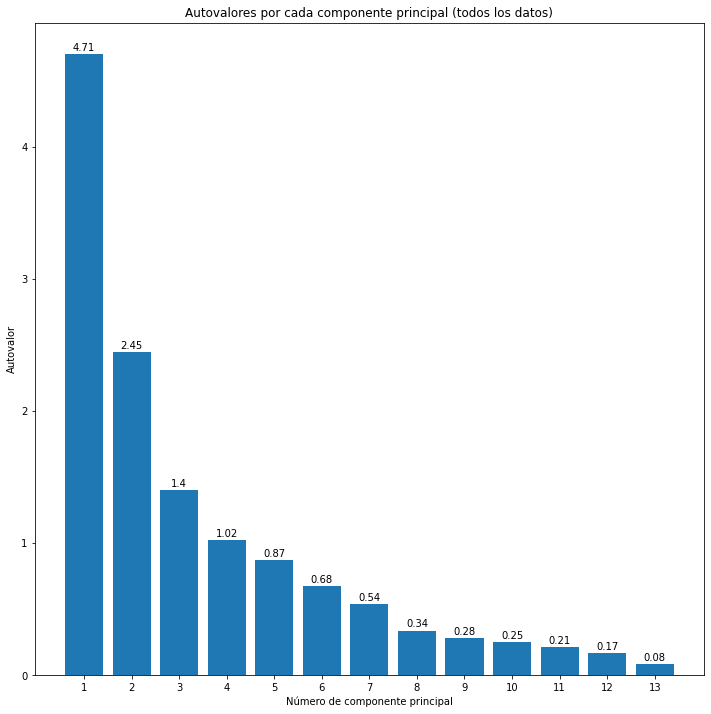

In [47]:
def encontrar_todos_los_autovalores(X):
    """
    Encuentra todos los autovalores de la matriz de covarianza para un conjunto de datos X.

    Parameters:
    - X (numpy.ndarray): Conjunto de datos.

    Returns:
    - autovalores (numpy.ndarray): Todos los autovalores de la matriz de covarianza.
    """
    # Número de características en el conjunto de datos
    m = X.shape[1]

    X_norm, _, _ = normalizar_datos(X_train)
    XTX = matriz_covarianza(X_norm)
    autovalores, _ = encontrar_autovalores(XTX, m)
    return autovalores

autovalores = encontrar_todos_los_autovalores(X)

plt.bar(range(1, len(autovalores)+1), autovalores)
for i, v in enumerate(autovalores):
    plt.text(i+1, v+0.01, str(round(v, 2)), ha='center', va='bottom')
plt.title('Autovalores por cada componente principal (todos los datos)')
plt.xlabel('Número de componente principal')
plt.ylabel('Autovalor')
plt.xticks(range(1, len(autovalores)+1))
plt.show()

Se obserban ligeras diferencias entre las dos formas de calcular los autovalores. Continuamos utilizando solo datos de entrenamiento asumiendo que en esta sección el análisis es siempre sobre datos de entrenamiento.

### Varianza Explicada

Definiendo la varianza explicada de cada autovector como:

$$\large \text{Varianza\_explicada}(i) = \frac {\lambda_i}{\sum_{j=1}^n \lambda_j}$$

donde $\lambda_i$ es el autovalor $i$ correspondiente, y $n$ la cantidad **total** de autovalores, podemos calcularla como:

In [48]:
n = 4
for i in range(n):
    a = autovalores[0:i+1] / autovalores.sum()
    print(f"{i+1} componente: Varianza explicada: {a.round(2)}")


1 componente: Varianza explicada: [0.36]
2 componente: Varianza explicada: [0.36 0.19]
3 componente: Varianza explicada: [0.36 0.19 0.11]
4 componente: Varianza explicada: [0.36 0.19 0.11 0.08]


### Tabla

| Modelo PCA | Componente | Varianza Explicada | Porcentaje | Acumulado |
|---|---|---|---|---|
| 1 Componente Principal | 1 | 0.36 | 36 % | 36 %| 
| | | | | |
| 2 Componentes Principales | 1 | 0.36 | 36 % | 36 %| 
|  | 2 | 0.19 | 19 % | 55 % |
| | | | | |
| 3 Componentes Principales | 1 | 0.36 | 36 % | 36 %| 
|  | 2 | 0.19 | 19 % | 55 % |
|  | 3 | 0.11 | 11 % | 66 % |
| | | | | |
| 4 Componentes Principales | 1 | 0.36 | 36 % | 36 %| 
|  | 2 | 0.19 | 19 % | 55 % |
|  | 3 | 0.11 | 11 % | 66 % |
|  | 4 | 0.07 | 7 % | 73 % |
| | | | | |


Podemos ver cómo con 4 componentes principales (de un total de 13 variables) se captura un 73 % de la varianza.

Considerando los resultados anteriores, solo con 2 o 3 componentes principales alcanza para tener la mejor performance, por lo que podemos decir que con un 55-66% de la varianza podemos predecir nuevos datos con muy buena precision (alrededor de 1.4 errores por cada 36 ejemplos de test, o sea, un 0.96% de precisión).



### Gráficos de resultados

In [49]:
X_train, y_train, X_test, y_test = dividir_dataset(X, y)
X_train, X_mean, X_std = normalizar_datos(X_train)

In [50]:
def map_color(y):
    """
    Dado un vector de etiquetas, devuelve un vector con los colores correspondientes.

    Parameters:
    - y (numpy.ndarray): Vector de etiquetas.

    Returns:
    - colors (list): Lista de colores correspondientes a las etiquetas.
    """
    # Mapeo de números a colores
    NUMTOCOL = {1: 'blue', 2: 'red', 3: 'green'}

    colors = [NUMTOCOL[num] for num in y]
    
    return colors

In [51]:
def graficar_clasificacion1D2D(X_train_pca, X_test_pca, y_train, y_test, y_pred):
    """
    Grafica la clasificación de datos en 1D o 2D.

    Parameters:
    - X_train_pca (numpy.ndarray): Datos de entrenamiento proyectados en componentes principales.
    - X_test_pca (numpy.ndarray): Datos de prueba proyectados en componentes principales.
    - y_train (numpy.ndarray): Etiquetas de los datos de entrenamiento.
    - y_test (numpy.ndarray): Etiquetas de los datos de prueba.
    - y_pred (numpy.ndarray): Etiquetas predichas.

    Returns:
    - None
    """
    # Verifico que X_train_pca tenga solo 1 o 2 columnas para poder graficar
    X_dim = X_train_pca.shape[1]
    assert X_dim in [1, 2], "X_train_pca debe tener solo 1 o 2 columnas para poder graficarlas"

    # Predicciones correctas e incorrectas
    correct = y_pred == y_test
    incorrect = y_pred != y_test

    # Colormap para las clases
    cmap = ListedColormap(['red', 'blue', 'green'])

    if X_dim == 1:
        # Para 1D, establece la segunda dimensión en 0
        X_train_pca_2nd = [0] * len(X_train_pca)
        X_test_pca_correct_2nd = [0] * sum(correct)
        X_test_pca_incorrect_2nd = [0] * sum(incorrect)
    else:
        # Para 2D, toma la segunda columna de X_train_pca
        X_train_pca_2nd = X_train_pca[:, 1]
        X_test_pca_correct_2nd = X_test_pca[correct, 1]
        X_test_pca_incorrect_2nd = X_test_pca[incorrect, 1]

    # Grafico los datos de entrenamiento, predicciones correctas e incorrectas
    plt.scatter(X_train_pca[:, 0], X_train_pca_2nd,
                c=map_color(y_train), marker='.',
                label='Datos de Entrenamiento')

    plt.scatter(X_test_pca[correct, 0], X_test_pca_correct_2nd,
                c=map_color(y_pred[correct]), marker='s',
                label='Predicción correcta')

    plt.scatter(X_test_pca[incorrect, 0], X_test_pca_incorrect_2nd,
                c=map_color(y_test[incorrect]), marker='o', s=200,
                label='Etiqueta real')

    plt.scatter(X_test_pca[incorrect, 0], X_test_pca_incorrect_2nd,
                c=map_color(y_pred[incorrect]), marker='x', s=300, linewidths=2,
                label='Predicción errada')

    plt.xlabel('Componente Principal 1')
    if X_dim == 1:
        # Elimina las marcas en el eje y
        plt.yticks([])
    else:
        plt.ylabel('Componente Principal 2')
    
    plt.legend()
    plt.title(f'Clasificación de datos de testeo - {sum(incorrect)} error/es de {len(y_test)} datos')

    # Crea un ScalarMappable para visualizar la barra de colores
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ticks=[1, 2, 3], label='Clase', boundaries=[0.5, 1.5, 2.5, 3.5])
    plt.show()

#### 1 Componente

Viendo los resultados promedios anteriores, para 1 sola componente principal y 14 vecinos, podemos esperar alrededor de 5.7 errores por cada 36 casos de test. En este caso veremos que serán 7 errores.

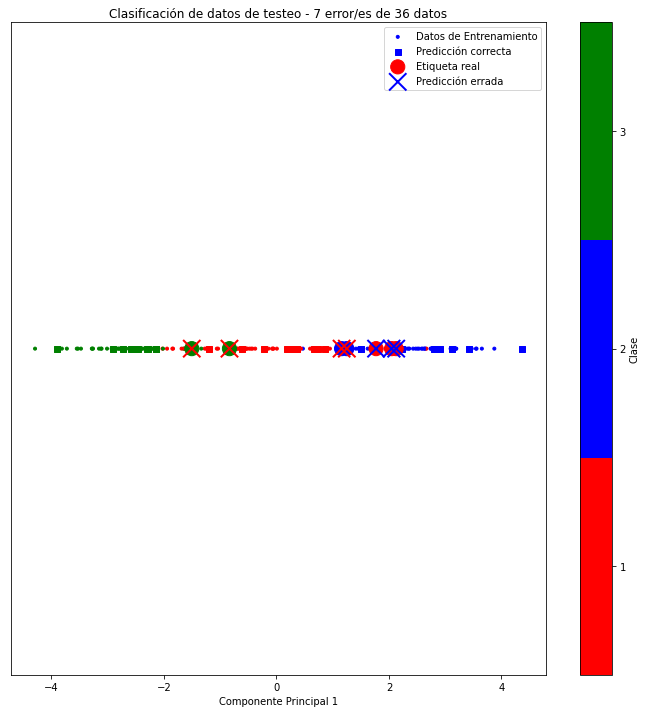

In [52]:
n = 1
k = 14

autovalores, W_pca = calcular_pca(X_train, n)
X_train_pca = proyectar_datos(X_train, W_pca)
X_test_pca, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)

graficar_clasificacion1D2D(X_train_pca, X_test_pca, y_train, y_test, y_pred)

Es de esperarse que una sola componente principal sea insuficiente para separar los datos, ya que estamos proyectando todos los puntos sobre una única recta que apunta en la dirección de mayor varianza.

#### 2 Componentes

Viendo los resultados promedios anteriores, para 2 componentes principales y 17 vecinos se obtuvieron los mejores resultados con 1.4 errores promedio. En este caso tenemos una clasificación perfecta sin ningún error:

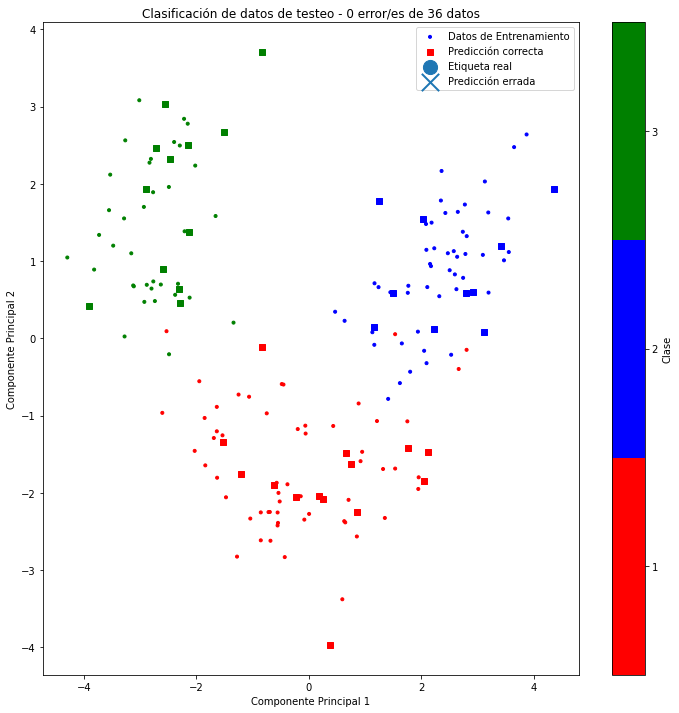

In [53]:
n = 2
k = 17

autovalores, W_pca = calcular_pca(X_train, n)
X_train_pca = proyectar_datos(X_train, W_pca)
X_test_pca, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)

graficar_clasificacion1D2D(X_train_pca, X_test_pca, y_train, y_test, y_pred)

Pero cambiando la cantidad de vecinos podemos ver que también pueden existir errores:

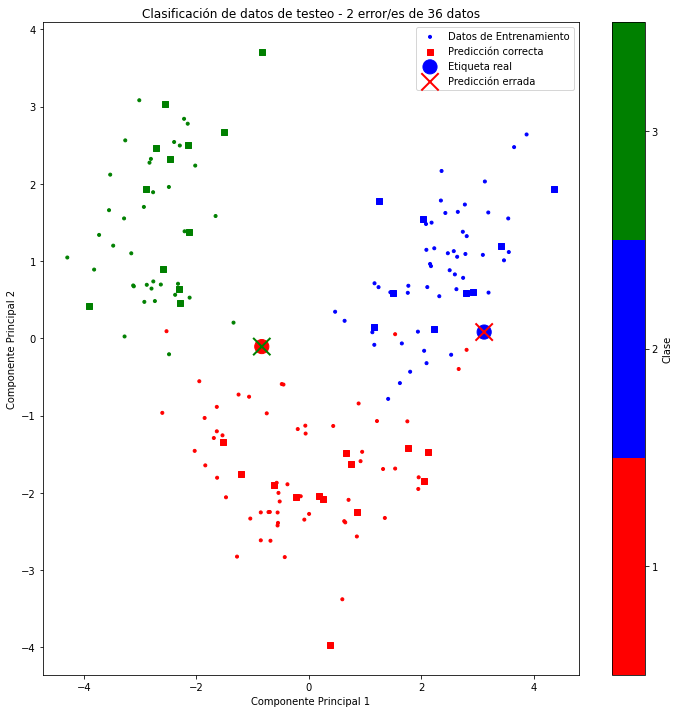

In [54]:
n = 2
k = 1

autovalores, W_pca = calcular_pca(X_train, n)
X_train_pca = proyectar_datos(X_train, W_pca)
X_test_pca, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)

graficar_clasificacion1D2D(X_train_pca, X_test_pca, y_train, y_test, y_pred)

#### 3 Componentes

Para 3 dimensiones vamos a definir una segunda función graficadora utilizando la libreria Plotly que permite interactuar con el gráfico, rotarlo en el espacio, hacer zoom, etc.

In [55]:
def graficar_clasificacion3D(X_train_pca, X_test_pca, y_train, y_test, y_pred):
    """
    Grafica la clasificación de datos en 3D.

    Parameters:
    - X_train_pca (numpy.ndarray): Datos de entrenamiento proyectados en componentes principales.
    - X_test_pca (numpy.ndarray): Datos de prueba proyectados en componentes principales.
    - y_train (numpy.ndarray): Etiquetas de los datos de entrenamiento.
    - y_test (numpy.ndarray): Etiquetas de los datos de prueba.
    - y_pred (numpy.ndarray): Etiquetas predichas.

    Returns:
    - None
    """
    X_dim = X_train_pca.shape[1]
    assert X_dim == 3, "X_train_pca debe tener 3 columnas para poder graficar en 3D"

    # Colores para las clases en el conjunto de entrenamiento
    colors = map_color(y_train)
    
    fig = go.Figure()

    # Datos de entrenamiento
    fig.add_trace(go.Scatter3d(x=X_train_pca[:, 0], y=X_train_pca[:, 1], z=X_train_pca[:, 2],
                               mode='markers', marker=dict(color=colors, size=4),
                               name='Datos de Entrenamiento'))
    
    # Predicciones correctas
    fig.add_trace(go.Scatter3d(x=X_test_pca[y_pred == y_test, 0], y=X_test_pca[y_pred == y_test, 1], z=X_test_pca[y_pred == y_test, 2],
                               mode='markers', marker=dict(color=map_color(y_pred[y_pred == y_test]), size=4),
                               name='Predicción correcta'))

    # Etiquetas reales
    fig.add_trace(go.Scatter3d(x=X_test_pca[y_pred != y_test, 0], y=X_test_pca[y_pred != y_test, 1], z=X_test_pca[y_pred != y_test, 2],
                               mode='markers', marker=dict(color=map_color(y_test[y_pred != y_test]), size=8),
                               name='Etiqueta real'))

    # Predicciones incorrectas
    fig.add_trace(go.Scatter3d(x=X_test_pca[y_pred != y_test, 0], y=X_test_pca[y_pred != y_test, 1], z=X_test_pca[y_pred != y_test, 2],
                               mode='markers', marker=dict(color=map_color(y_pred[y_pred != y_test]), symbol='x', size=4),
                               name='Predicción errada'))

    fig.update_layout(title_text=f'Clasificación de datos de testeo - {sum(y_pred != y_test)} error/es de {len(y_test)} datos',
                      scene=dict(aspectmode="cube"),
                      scene_xaxis_title='Componente Principal 1',
                      scene_yaxis_title='Componente Principal 2',
                      scene_zaxis_title='Componente Principal 3',
                      legend=dict(x=0, y=1.0, orientation='h'),
                      height=800)

    fig.show()

Para 3 componentes principales, el error es cercano a 1.5 para casi cualquier valor de vecino: 

In [56]:
n = 3
k = 4

autovalores, W_pca = calcular_pca(X_train, n)
X_train_pca = proyectar_datos(X_train, W_pca)
X_test_pca, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)

graficar_clasificacion3D(X_train_pca, X_test_pca, y_train, y_test, y_pred)

### $(c)$ Matriz de Confusión

En esta sección analizaremos los mejores 4 modelos entre los promedios analizados anteriormente:

* 1 componente principal y 10 vecinos
* 2 componentes principales y 17 vecinos
* 3 componentes principales y 4 vecinos
* 4 componentes principales y 15 vecinos

In [57]:
params = [(1, 10),
          (2, 17),
          (3, 4),
          (4, 15)] 

In [58]:
def matriz_confusion(y_real, y_pred):
    """
    Calcula una matriz de confusión a partir de una lista de etiquetas reales y una lista de etiquetas predichas.

    Parameters:
    - y_real (list): Lista de etiquetas reales, valores entre 1 y 3.
    - y_pred (list): Lista de etiquetas predichas, valores entre 1 y 3.

    Returns:
    - np.ndarray: Matriz de confusión, donde las filas representan las etiquetas reales y las columnas representan las etiquetas predichas.
    """
    # Inicializa la matriz de confusión
    conf_mat = np.zeros((3, 3))

    # Rellena la matriz de confusión
    for i in range(len(y_real)):
        conf_mat[y_real[i] - 1, y_pred[i] - 1] += 1

    return conf_mat


In [59]:
def obtener_errores(X, y, params, iteraciones=200):
    """
    Dada una matriz de datos X, un vector de etiquetas y, una lista de tuplas de parámetros (n, k),
    y un número de iteraciones, devuelve una lista de matrices de confusión promedio para cada par de parámetros.

    Parameters:
    - X (numpy.ndarray): Matriz de datos.
    - y (numpy.ndarray): Vector de etiquetas.
    - params (list): Lista de tuplas (n, k) representando los parámetros para la PCA y KNN.
    - iteraciones (int): Número de iteraciones para promediar las matrices de confusión.

    Returns:
    - list: Lista de matrices de confusión promedio para cada par de parámetros.
    """
    matrices_de_confusion = []
    
    # Recorro la lista de parámetros (n, k)
    for n, k in tqdm(params):
        sum_matrices = np.zeros((3, 3))
        
        # Realizo iteraciones para promediar matrices de confusión con distintos conjuntos de
        # entrenamiento y testeo
        for i in range(iteraciones):
            X_train, y_train, X_test, y_test = dividir_dataset(X, y)
            X_train, X_mean, X_std = normalizar_datos(X_train)
            _, W_pca = calcular_pca(X_train, n)
            X_train_pca = proyectar_datos(X_train, W_pca)
            
            # Ejecuto el modelo para obtener predicciones
            _, y_pred = ejecutar_modelo(X_test, X_train_pca, y_train, W_pca, X_mean, X_std, n, k)
            
            # Acumulo matriz de confusión de este modelo con n, k particular
            sum_matrices += matriz_confusion(y_test, y_pred)
        
        # Guardo el promedio de matrices de confusión para este modelo con n, k particular
        matrices_de_confusion.append(sum_matrices/iteraciones)
            
    return matrices_de_confusion


In [60]:
# Calculo matrices de confusión para los modelos previamente mencionados
matrices_de_confusion = obtener_errores(X, y, params)

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


In [61]:
def graficar_matrices_de_confusion(params, matrices_de_confusion):
    """
    Grafica las matrices de confusión para diferentes configuraciones de n y k.

    Parameters:
    - params (list): Lista de tuplas (n, k) que representan las configuraciones de n y k.
    - matrices_de_confusion (list): Lista de matrices de confusión correspondientes a cada configuración.

    Returns:
    None
    """

    for (n, k), mat_de_conf in zip(params, matrices_de_confusion):
        # Crea una figura y ejes
        fig, ax = plt.subplots(figsize=(5, 5))

        # Muestra la matriz de confusión en una gráfica de colores (heatmap)
        cax = ax.matshow(mat_de_conf, cmap='Reds', vmin=0, vmax=estadisticas.max())

        # Agrega los valores de la matriz en cada celda
        for i in range(mat_de_conf.shape[0]):
            for j in range(mat_de_conf.shape[1]):
                ax.text(j, i, f'{mat_de_conf[i, j].round(2)}', va='center', ha='center',
                        color=colorear_error(mat_de_conf[i, j]),
                        fontweight='bold' if mat_de_conf[i, j] == 0 else 'normal')

        # Configura los ticks del eje x
        ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

        # Configura las etiquetas de los ticks en el eje x e y
        ax.set_xticks(range(mat_de_conf.shape[1]))
        ax.set_yticks(range(mat_de_conf.shape[0]))
        ax.set_xticklabels(range(1, 4))
        ax.set_yticklabels(range(1, 4))

        # Muestra los ticks en la parte superior del eje x
        ax.tick_params(axis='x', bottom=True, top=True, labelbottom=True, labeltop=True)

        # Configura el título y las etiquetas de los ejes
        plt.title(f'Modelo {n}\nMatriz de confusión para n={n} y k={k}', pad=30, fontsize=12, fontweight='bold', color='gray', loc='left')
        plt.xlabel('Clases Predichas')
        plt.ylabel('Clases Reales')
        plt.show()


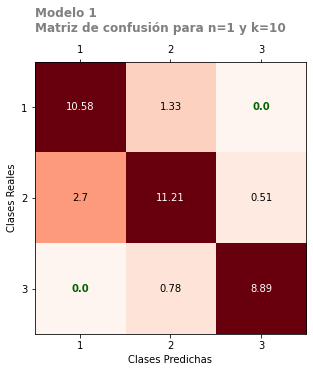

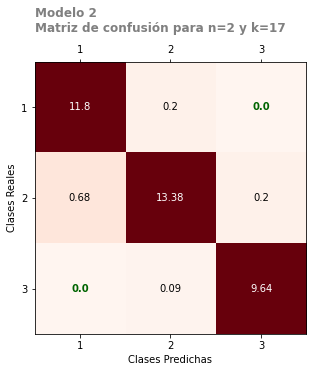

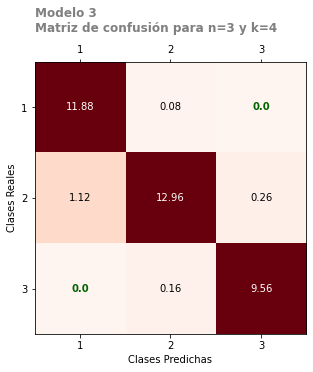

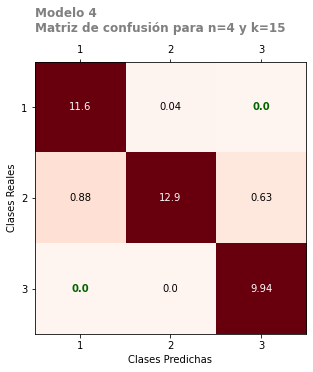

In [62]:
graficar_matrices_de_confusion(params, matrices_de_confusion)

#### Modelo 1:

En la matriz de confusión para el modelo de 1 componente principal y 10 vecinos, la mayor proporción de errores se da cuando la clase real es 1 y el modelo la confunde con la clase 2, y el segundo error más común es cuando la clase real es 2 y el modelo predice 1.

Comparando estos valores con el gráfico de 1 componente principal (1 dimensión) podemos ver que varios puntos de las clases 1 y 2 se superponen sobre los conjuntos de sus respectivas clases, haciendo imposible para el algoritmo KNN poder separar estos conjuntos de datos sin errores.

Con las clases 2 y 3 pasa algo parecido pero en menor medida.

Con las clases 1 y 3 ocurre el caso que podría considerarse más interesante para este modelo: El error es siempre cero, pues viendo el gráfico de 1 dimensión se observa que estas 2 clases están perfectamente separadas en conjuntos disjuntos (aunque entre ellas hay puntos de la clase 2).

#### Modelo 2:

Para dos componentes principales, los puntos esparcidos en el plano son más facilmente separables por KNN, por lo que se reduce drásticamente la cantidad de errores. De todas formas, el error más común sigue siendo que el modelo prediga 1 cuando debería ser 2, y el segundo error más común es cuando el modelo predice 2 cuando debería ser 1.

Si en una dimensión las clases 1 y 3 eran perfectamente separables, en 2 dimensiones lo seguirán siendo, por lo que ese error sigue siendo cero.

#### Modelo 3:

Con 3 componentes principales la performance no mejora, sino que en algunos casos hasta empeora. Dada la naturaleza estocástica del análisis, es dificil concluir algo certero con diferencias decimales tan pequeñas entre las matrices de confusión, pero algo que podría tenerse en cuenta es que el modelo sigue confundiendo la clase real 2 con la clase 1 a pesar de haber agregado una nueva dimensión, y hasta con mayor error que antes, por lo que es posible que los datos contengan un error de etiqueta, y en verdad la clase real es la que predice el modelo, y no la que establecen los datos.

En este caso se podría consultar a la empresa de vinos para que, mediante su expertise en el tema, puedan confirmar si el error del modelo es justificado, o es un error que no debería ocurrir.

#### Modelo 4:

Las mejoras en los resultados son muy pequeñas, y hasta en algunos casos, peores que en modelos anterios. Agregar una cuarta dimensión no parece aportar ningún tipo de información relevante para la clasificación de los vinos mediante KNN (aunque tal vez sí lo hace usando algún otro modelo de clasificación).

# Conclusión




En este trabajo pudieron implementarse las ideas detrás de PCA que permiten aprovechar la reducción de dimensionalidad de un conjunto de datos para su posterior clasificación.
Utilizando una única componente principal podemos esperar un error promedio del 16% con unos 10 vecinos, lo cual es un resultado muy bueno considerando que el conjunto de datos tiene 3 clases, con lo que un modelo aleatorio tendría un error promedio del 66%, y partiendo de que los datos originales tenían 13 características.

Se pudo observar que el error de clasificación disminuye bastante agregando una segunda componente alcanzando un 4% de error, pero las mejoras son menores al agregar una tercera componente, y son nulas al agregar una cuarta.

Por lo tanto se concluye que para este dataset y dados los requerimientos del comercio, la opción óptima es usar 2 componentes principales y entre 17 y 25 vecinos cercanos.

Asumimos que la cantidad de vecinos **no** influye en el tiempo de ejecución del algoritmo, ya que considerar más o menos vecinos es despreciable con respecto al tiempo que toma ordenar los puntos por distancia, **usando nuestra implementación**.

Es posible que exista una forma más eficiente de implementar KNN donde la cantidad de vecinos a considerar requiera menor tiempo de ejecución cuanto menor sea la cantidad de vecinos a considerar, por lo que en ese caso habría que tener en cuenta el modelo con 3 componentes principales, ya que a pesar de tener una columna más en la matriz de proyección $W$, la cantidad de vecinos necesarios para alcanzar la misma performance que con 2 componentes es 4, mientras que con solo 2 componentes principales la cantidad de vecinos está entre 17 y 25.

